# 🧠 Xception Transfer Learning - Image Classification
This notebook demonstrates how to use Xception with transfer learning on a small custom dataset.

### Import libraries

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
import zipfile
from tensorflow.keras.models import load_model

### Google Drive dataset

### Dataset Link :- https://drive.google.com/file/d/1TCU1nqgIe1R_dW6LTkRxlufHlCCazyJl/view?usp=sharing

In [2]:
# Google Drive file ID
file_id = "1TCU1nqgIe1R_dW6LTkRxlufHlCCazyJl"
# Download destination filename
output = "myfile.zip"

# Download the file
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1TCU1nqgIe1R_dW6LTkRxlufHlCCazyJl
From (redirected): https://drive.google.com/uc?id=1TCU1nqgIe1R_dW6LTkRxlufHlCCazyJl&confirm=t&uuid=5de15ba9-38d1-4431-9848-43ae4e7a7577
To: /content/myfile.zip
100%|██████████| 63.9M/63.9M [00:02<00:00, 30.4MB/s]


'myfile.zip'

### Extract files

In [3]:
with zipfile.ZipFile("myfile.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

### Define paths

In [4]:
train_dir = "/content/dataset/train"
val_dir = "/content/dataset/valid"
img_size = 299
batch_size = 32

### Data generators

In [5]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 1275 images belonging to 2 classes.
Found 364 images belonging to 2 classes.


### Load base model

In [6]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
base_model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add[0][0]       

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

### Add custom classifier

In [9]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


###Compile the model

In [10]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


###Train the model

In [11]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.6216 - loss: 0.6719 - val_accuracy: 0.8901 - val_loss: 0.4992
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 857ms/step - accuracy: 0.8069 - loss: 0.5053 - val_accuracy: 0.9176 - val_loss: 0.3949
Epoch 3/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 879ms/step - accuracy: 0.8551 - loss: 0.4212 - val_accuracy: 0.9148 - val_loss: 0.3315
Epoch 4/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 879ms/step - accuracy: 0.8825 - loss: 0.3634 - val_accuracy: 0.9176 - val_loss: 0.2911
Epoch 5/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 34s 856ms/step - accuracy: 0.8854 - loss: 0.3360 - val_accuracy: 0.9176 - val_loss: 0.2633
Epoch 6/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 869ms/step - accuracy: 0.8931 - loss: 0.3137 - val_accuracy: 0.9176 - val_loss: 0.2430
Epoch 7/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 33s 821ms/step - accuracy: 0.9007 - loss: 0.2897 - val_accuracy: 0.9148 - val_loss: 0.2298
Epoch 8/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 33s 821ms/step - accuracy: 0.9163 - loss: 0.2562 - val_accura

### Plot training history

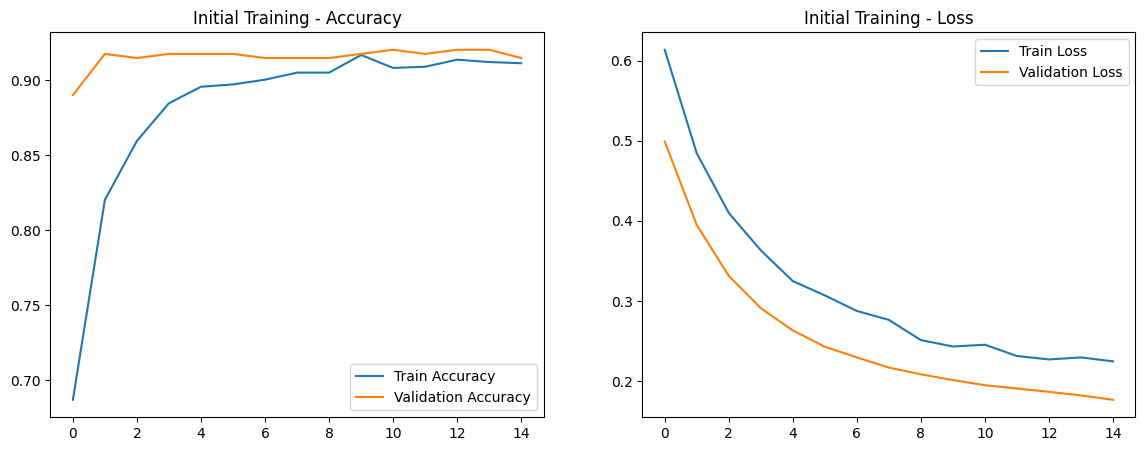

In [12]:
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.show()

plot_history(history, "Initial Training")


### Save model

In [14]:
model.save("xception_transfer_learning_model.keras")

### Load Model.keras

In [15]:
model = load_model("xception_transfer_learning_model.keras")

### Prediction function

In [16]:
def predict_image(model, image_path):
    img = load_img(image_path, target_size=(299, 299))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.xception.preprocess_input(img_array)

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    class_indices = {v: k for k, v in train_generator.class_indices.items()}
    return class_indices[predicted_class[0]]

### Example 1:

In [17]:
image_path = "/content/dataset/test/daisy/14613443462_d4ed356201_jpg.rf.76462b3f0cb5ca5a0b4b7c9894feb91c.jpg"  # Update path accordingly
predicted_label = predict_image(model, image_path)
print("Predicted Label:", predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
Predicted Label: daisy


### Example 2:

In [18]:
image_path = "/content/dataset/test/dandelion/14060367700_fe87e99b6a_m_jpg.rf.eaf8222cde370b2ebb4d6a1378ec07b1.jpg"  # Update path accordingly
predicted_label = predict_image(model, image_path)
print("Predicted Label:", predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted Label: dandelion
